In [2]:
import py7zr
import pandas as pd
import os
from tqdm import tqdm
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
import calendar
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the paths to the .7z files and the extraction directory
archive_paths = [
    '/work/pi_atreya_chakraborty_umb_edu/Captsone/Data/analyst_recommendation.7z',
    '/work/pi_atreya_chakraborty_umb_edu/Captsone/Data/crsp_data.7z'
]
extraction_base_path = '/work/pi_atreya_chakraborty_umb_edu/Captsone/Data/extracted'

# Loop 1: Extract the .7z files
for archive_path in archive_paths:
    # Create a unique extraction directory for each archive
    extraction_path = os.path.join(extraction_base_path, os.path.splitext(os.path.basename(archive_path))[0])
    
    # Extract the .7z file
    with py7zr.SevenZipFile(archive_path, mode='r') as z:
        z.extractall(path=extraction_path)
    
    print(f"Extracted contents of {archive_path} to {extraction_path}.", flush=True)

Extracted contents of /work/pi_atreya_chakraborty_umb_edu/Captsone/Data/analyst_recommendation.7z to /work/pi_atreya_chakraborty_umb_edu/Captsone/Data/extracted/analyst_recommendation.
Extracted contents of /work/pi_atreya_chakraborty_umb_edu/Captsone/Data/crsp_data.7z to /work/pi_atreya_chakraborty_umb_edu/Captsone/Data/extracted/crsp_data.


In [3]:
analyst_rec = pd.read_stata("/work/pi_atreya_chakraborty_umb_edu/Captsone/Data/extracted/analyst_recommendation/analyst_recommendation.dta")
crsp_data = pd.read_stata("/work/pi_atreya_chakraborty_umb_edu/Captsone/Data/extracted/crsp_data/crsp_data.dta")

# Lowercase all column names for analyst_rec dataframe
analyst_rec.columns = analyst_rec.columns.str.lower()

# Lowercase all column names for crsp_data dataframe
crsp_data.columns = crsp_data.columns.str.lower()

# Drop rows with empty strings or NaN values in the 'cusip' column of crsp_data
crsp_data = crsp_data[crsp_data['cusip'].notna() & (crsp_data['cusip'] != '')]

# Drop rows with empty strings or NaN values in the 'cusip' column of analyst_rec
analyst_rec = analyst_rec[analyst_rec['cusip'].notna() & (analyst_rec['cusip'] != '')]

print("Done loading data", flush=True)

Done loading data


In [16]:
analyst_rec.head()

,ticker,cusip,cname,oftic,actdats,estimid,analyst,ereccd,etext,ireccd,itext,emaskcd,amaskcd,usfirm,acttims,revdats,revtims,anndats,anntims,year
0,0000,87482X10,TALMER BANCORP,TLMR,2014-03-10,RBCDOMIN,ARFSTROM J,2,OUTPERFORM,2,BUY,659.0,71182.0,1.0,1960-01-01 08:54:02.999,2016-01-26,1960-01-01 09:35:52,2014-03-10,1960-01-01 00:20:00,2014
1,0000,87482X10,TALMER BANCORP,TLMR,2014-03-11,JPMORGAN,ALEXOPOULOS S,,OVERWEIGHT,2,BUY,1243.0,79092.0,1.0,1960-01-01 17:10:47.000,2016-01-26,1960-01-01 10:09:34,2014-03-10,1960-01-01 00:25:00,2014
2,0000,87482X10,TALMER BANCORP,TLMR,2014-03-11,KEEFE,MCGRATTY C,2,OUTPERFORM,2,BUY,1308.0,119962.0,1.0,1960-01-01 15:17:15.000,2015-07-30,1960-01-01 07:25:58,2014-03-09,1960-01-01 17:05:00,2014
3,0000,87482X10,TALMER BANCORP,TLMR,2014-03-11,RAYMOND,LONG D,1,STRONG BUY,1,STRONG BUY,1929.0,80474.0,1.0,1960-01-01 15:49:22.000,2016-01-19,1960-01-01 08:06:44,2014-03-10,1960-01-01 06:48:00,2014
4,0000,87482X10,TALMER BANCORP,TLMR,2014-03-11,STERNE,GREEN P,2,NEUTRAL,3,HOLD,2209.0,50789.0,1.0,1960-01-01 15:22:08.000,2014-11-07,1960-01-01 12:20:17,2014-03-10,1960-01-01 07:45:00,2014


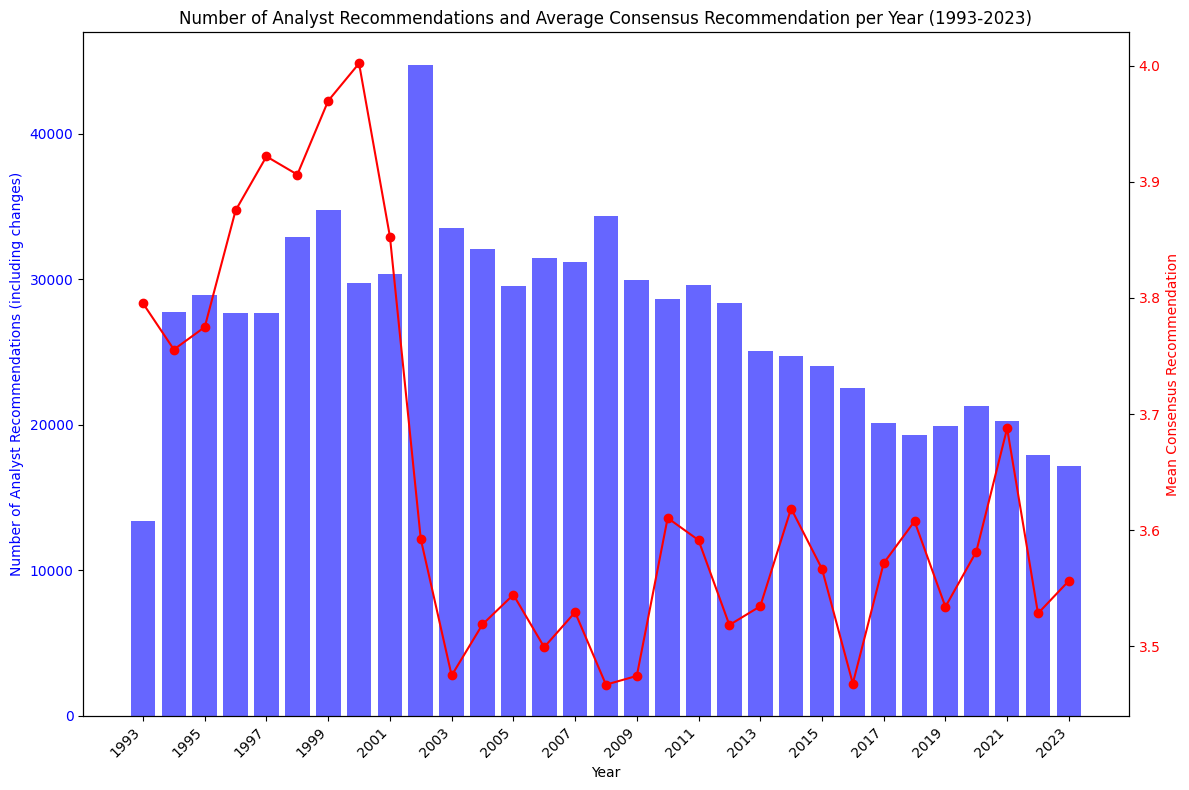

In [21]:
#Exploratory Data Analysis
# Convert the anndats column to datetime
analyst_rec['anndats'] = pd.to_datetime(analyst_rec['anndats'])

# Extract year from the anndats column
analyst_rec['year'] = analyst_rec['anndats'].dt.year

# Convert ireccd to numeric, coercing any non-numeric values to NaN
analyst_rec['ireccd'] = pd.to_numeric(analyst_rec['ireccd'], errors='coerce')

# Filter for years between 1993 and 2023
analyst_rec_filtered = analyst_rec[(analyst_rec['year'] >= 1993) & (analyst_rec['year'] <= 2023)]

# Group by year to get the count of recommendations and average ireccd
yearly_data = analyst_rec_filtered.groupby('year').agg(
    count_recommendations=('ticker', 'count'),
    avg_ireccd_transformed=('ireccd', lambda x: (6 - x).mean())
).reset_index()

# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot number of analyst recommendations (bar plot)
ax1.bar(yearly_data['year'], yearly_data['count_recommendations'], color='blue', alpha=0.6, label='Count of Recommendations')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Analyst Recommendations (including changes)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Rotate x-axis labels and reduce the number of ticks
ax1.set_xticks(yearly_data['year'][::2])  # Show every second year
ax1.set_xticklabels(yearly_data['year'][::2], rotation=45, ha='right')

# Create a second y-axis for the transformed ireccd
ax2 = ax1.twinx()
ax2.plot(yearly_data['year'], yearly_data['avg_ireccd_transformed'], color='red', marker='o', label='Mean Consensus Recommendation')
ax2.set_ylabel('Mean Consensus Recommendation', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout adjustments
plt.title('Number of Analyst Recommendations and Average Consensus Recommendation per Year (1993-2023)')
fig.tight_layout()

# Save the plot as an image
plt.savefig('EDA_plot.png')

# Show the plot
plt.show()

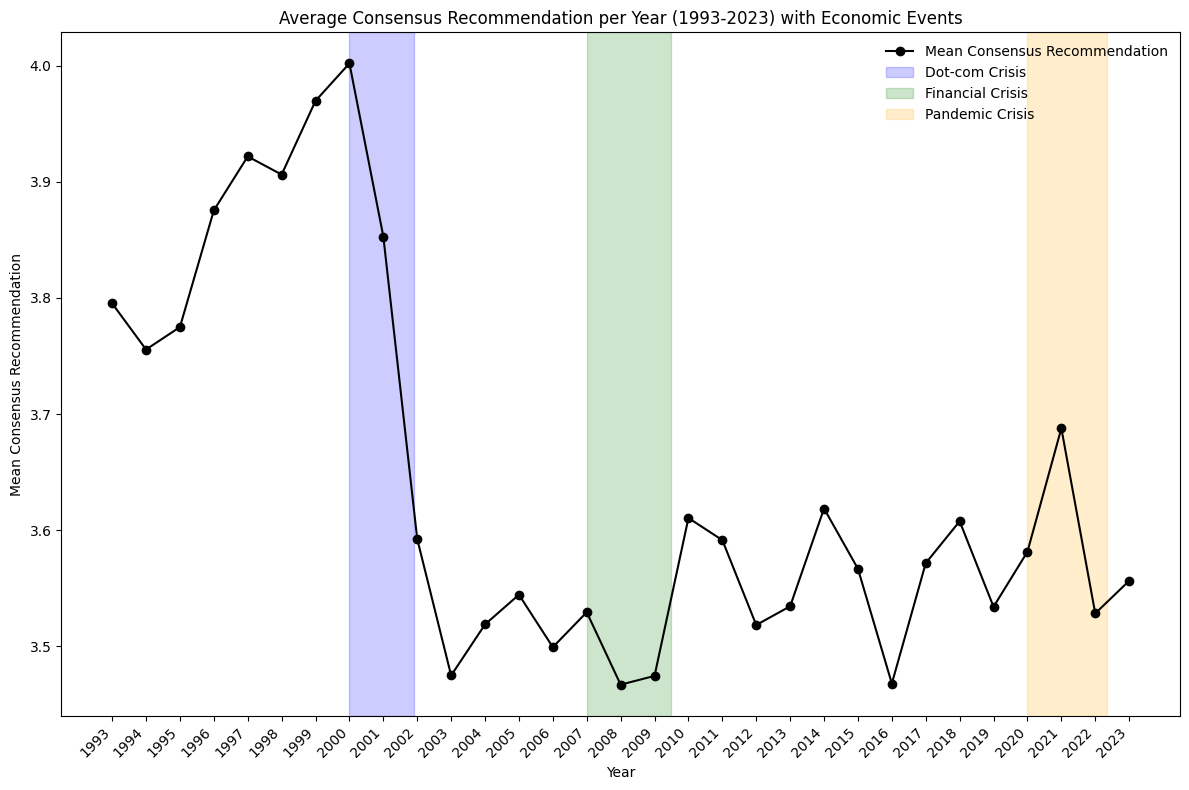

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the anndats column to datetime
analyst_rec['anndats'] = pd.to_datetime(analyst_rec['anndats'])

# Extract year from the anndats column
analyst_rec['year'] = analyst_rec['anndats'].dt.year

# Convert ireccd to numeric, coercing any non-numeric values to NaN
analyst_rec['ireccd'] = pd.to_numeric(analyst_rec['ireccd'], errors='coerce')

# Filter for years between 1993 and 2023
analyst_rec_filtered = analyst_rec[(analyst_rec['year'] >= 1993) & (analyst_rec['year'] <= 2023)]

# Group by year to get the average ireccd
yearly_data = analyst_rec_filtered.groupby('year').agg(
    avg_ireccd_transformed=('ireccd', lambda x: (6 - x).mean())
).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot average consensus recommendation (line plot)
ax.plot(yearly_data['year'], yearly_data['avg_ireccd_transformed'], color='black', marker='o', label='Mean Consensus Recommendation')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Consensus Recommendation', color='black')
ax.tick_params(axis='y', labelcolor='black')

# Add shaded areas for Dot-com Bubble, Great Recession, and Pandemic Recession
ax.axvspan(2000, 2001 + 11/12, color='blue', alpha=0.2, label='Dot-com Crisis')  # March-November 2001
ax.axvspan(2007, 2009 + 6/12, color='green', alpha=0.2, label='Financial Crisis')  # December 2007 - June 2009
ax.axvspan(2020, 2022 + 4/12, color='orange', alpha=0.2, label='Pandemic Crisis')  # March-April 2020

# Title and layout adjustments
plt.title('Average Consensus Recommendation per Year (1993-2023) with Economic Events')

# Move the legend to the top-right corner
plt.legend(loc='upper right', frameon=False)

# Rotate x-axis labels for readability
plt.xticks(yearly_data['year'], rotation=45, ha='right')

# Tight layout and save the plot
fig.tight_layout()
plt.savefig('Average_Consensus_Recommendation_Yearly.png')

# Show the plot
plt.show()


In [31]:
# Convert the anndats column to datetime
analyst_rec['anndats'] = pd.to_datetime(analyst_rec['anndats'])

# Extract the year from anndats
analyst_rec['year'] = analyst_rec['anndats'].dt.year

# Define a function to calculate the descriptive statistics
def descriptive_stats(analyst_rec):
    # Group by year and calculate the required statistics
    yearly_stats = analyst_rec.groupby('year').agg(
        no_of_covered_firms=('cusip', pd.Series.nunique),  # Number of distinct firms
        no_of_brokers=('estimid', pd.Series.nunique),  # Number of distinct brokers or investment banks
        no_of_recommendations=('cusip', 'count'),  # Number of recommendations
        mean_analysts_per_firm=('analyst', lambda x: x.groupby(analyst_rec['cusip']).nunique().mean()),  # Mean analysts per firm
        median_analysts_per_firm=('analyst', lambda x: x.groupby(analyst_rec['cusip']).nunique().median()),  # Median analysts per firm
        mean_analysts_per_broker=('analyst', lambda x: x.groupby(analyst_rec['estimid']).nunique().mean()),  # Mean analysts per broker
        median_analysts_per_broker=('analyst', lambda x: x.groupby(analyst_rec['estimid']).nunique().median()),  # Median analysts per broker
        mean_firms_per_analyst=('cusip', lambda x: x.groupby(analyst_rec['analyst']).nunique().mean()),  # Mean covered firms per analyst
        median_firms_per_analyst=('cusip', lambda x: x.groupby(analyst_rec['analyst']).nunique().median()),  # Median covered firms per analyst
        no_of_analysts=('analyst', pd.Series.nunique),  # Number of distinct analysts
        avg_ireccd_transformed=('ireccd', lambda x: (6 - x).mean()),  # Mean transformed consensus recommendation
        median_ireccd_transformed=('ireccd', lambda x: (6 - x).median())  # Median transformed consensus recommendation
    ).reset_index()

    return yearly_stats

# Calculate the descriptive statistics table
descriptive_statistics_table = descriptive_stats(analyst_rec)
descriptive_statistics_table.to_csv("Descriptive.csv")

In [6]:
# Convert the 'anndats' column to datetime if not already done
analyst_rec['anndats'] = pd.to_datetime(analyst_rec['anndats'])

# Extract the year from 'anndats'
analyst_rec['year'] = analyst_rec['anndats'].dt.year

# Convert ireccd to numeric, coercing any non-numeric values to NaN
analyst_rec['ireccd'] = pd.to_numeric(analyst_rec['ireccd'], errors='coerce')

# List of brokers
brokers = [
    "ADAMS", "ARGUS", "ATLANEQU", "AVONDALE", "BACHE", "BAKER", "BARRING", "BEAR", "BERN", 
    "BLAIR", "BREAN", "BRILEY", "BTIG", "BUCK", "BURNS", "CANTORFZ", "CAPELEUR", "CLKA", 
    "CLUSA", "CRAIG", "CRUTTEN", "DAVIDSON", "EDWARDS", "FAHN", "FBOSTON", "FIRSTALB", 
    "FRCLAYSC", "FRIEDMAN", "GABELLCO", "GARTNER", "GHUNTER", "GKM", "GOLDMAN", "HALLUM", 
    "HILLIARD", "JANNEY", "JEFFEREG", "JOHNRICE", "JOLSON", "JPMORGAN", "KAUFBRO", "KEEFE", 
    "LADENBUR", "LAWRENCE", "LAZARD", "LEERINK", "LEGG", "LEHMAN", "LONGBOW", "MACQUARI", 
    "MAXIM", "MCDONALD", "MCLEOD", "MERRILL", "MIDEST", "MIZUSEC", "MKEEGAN", "MKMPARTN", 
    "MONTSEC", "MORGAN", "NEEDHAM", "NORTHLAN", "OLMSTEAD", "OPPEN", "PACCREST", "PACGROW", 
    "PICKERIN", "PIPER", "POINT", "RAYMOND", "RBCDOMIN", "ROBINSON", "SANDLER", "SCOAST", 
    "SCOTT", "SIDOTI", "STEPHENS", "STERNE", "STIFEL", "SUMMCAP", "SUSQUEH", "TDSI", 
    "THEBENCH", "UNTERBUR", "VANKASPR", "VIRGINIA", "WEISEL", "WHEAT", "WMJM", "WOLFE", "WOODGUND"
]

# Define a function to calculate descriptive statistics for each broker by year
def broker_yearly_stats(analyst_rec, brokers):
    stats = {}
    
    for broker in brokers:
        broker_data = analyst_rec[analyst_rec['estimid'] == broker]
        
        # Group by year and calculate the required statistics for each broker
        yearly_stats = broker_data.groupby('year').agg(
            no_of_covered_firms=('cusip', pd.Series.nunique),  # Number of distinct firms
            no_of_recommendations=('cusip', 'count'),  # Number of recommendations
            no_of_analysts=('analyst', pd.Series.nunique),  # Number of distinct analysts
            mean_firms_per_analyst=('cusip', lambda x: x.groupby(broker_data['analyst']).nunique().mean()),  # Mean covered firms per analyst
            avg_ireccd_transformed=('ireccd', lambda x: (6 - x).mean())  # Mean transformed consensus recommendation
        ).reset_index()
        
        stats[broker] = yearly_stats
    
    return stats

# Calculate the statistics for each broker
broker_stats = broker_yearly_stats(analyst_rec, brokers)

# Function to transform the statistics dictionary into a single table for each statistic
def create_stat_table(stat_name, broker_stats):
    # Initialize an empty dataframe to store the result
    result = pd.DataFrame()

    # Loop over each broker and extract the statistic of interest
    for broker, stats_df in broker_stats.items():
        if stat_name in stats_df.columns:
            # Set the 'year' as the index and rename the column to the broker name
            temp_df = stats_df.set_index('year')[[stat_name]].rename(columns={stat_name: broker})
            
            # Concatenate to the result dataframe
            result = pd.concat([result, temp_df.T], axis=0)

    # Transpose the dataframe so that brokers are rows and years are columns
    result = result.T

    return result

# Generate separate tables for each statistic
no_of_covered_firms_table = create_stat_table('no_of_covered_firms', broker_stats)
no_of_recommendations_table = create_stat_table('no_of_recommendations', broker_stats)
no_of_analysts_table = create_stat_table('no_of_analysts', broker_stats)
mean_firms_per_analyst_table = create_stat_table('mean_firms_per_analyst', broker_stats)
avg_ireccd_transformed_table = create_stat_table('avg_ireccd_transformed', broker_stats)

# Function to create the tables with brokers as rows and years as columns
def create_stat_table_flipped(stat_name, broker_stats):
    # Initialize an empty dataframe to store the result
    result = pd.DataFrame()

    # Loop over each broker and extract the statistic of interest
    for broker, stats_df in broker_stats.items():
        if stat_name in stats_df.columns:
            # Set the 'year' as the index and rename the column to the broker name
            temp_df = stats_df.set_index('year')[[stat_name]].rename(columns={stat_name: broker})
            
            # Concatenate to the result dataframe
            result = pd.concat([result, temp_df.T], axis=0)

    # Keep the brokers as rows and years as columns
    return result

# Generate separate tables for each statistic (flipped with brokers as rows and years as columns)
no_of_covered_firms_table_flipped = create_stat_table_flipped('no_of_covered_firms', broker_stats)
no_of_recommendations_table_flipped = create_stat_table_flipped('no_of_recommendations', broker_stats)
no_of_analysts_table_flipped = create_stat_table_flipped('no_of_analysts', broker_stats)
mean_firms_per_analyst_table_flipped = create_stat_table_flipped('mean_firms_per_analyst', broker_stats)
avg_ireccd_transformed_table_flipped = create_stat_table_flipped('avg_ireccd_transformed', broker_stats)


In [15]:
# Save the flipped tables to CSV files
no_of_covered_firms_table_flipped.to_csv("no_of_covered_firms_flipped.csv")
no_of_recommendations_table_flipped.to_csv("no_of_recommendations_flipped.csv")
no_of_analysts_table_flipped.to_csv("no_of_analysts_flipped.csv")
mean_firms_per_analyst_table_flipped.to_csv("mean_firms_per_analyst_flipped.csv")
avg_ireccd_transformed_table_flipped.to_csv("avg_ireccd_transformed_flipped.csv")

In [14]:
avg_ireccd_transformed_table_flipped.head()

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,1992
ADAMS,3.854545,3.576471,4.131387,3.909091,3.892683,3.918782,4.061135,3.902439,3.711111,3.829493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARGUS,NaN,NaN,NaN,NaN,5.000000,4.000000,4.225000,3.776699,3.571429,3.592593,...,3.930818,4.148387,4.071429,3.746479,4.000000,4.300699,3.884615,4.04,3.615385,NaN
ATLANEQU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.123596,3.243243,3.393443,3.220930,3.436782,3.486486,3.297297,3.30,NaN,NaN
AVONDALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.250000,4.285714,...,3.512397,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BACHE,3.842924,4.011513,3.872180,4.037175,4.083333,3.991617,4.078788,4.051821,3.396843,3.645313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Ensure the date columns are in datetime format, coerced to handle invalid parsing
crsp_data['dlycaldt'] = pd.to_datetime(crsp_data['dlycaldt'], errors='coerce')
analyst_rec['anndats'] = pd.to_datetime(analyst_rec['anndats'], errors='coerce')

# Create the week, year, and month columns in crsp_data based on dlycaldt
crsp_data['week'] = crsp_data['dlycaldt'].dt.isocalendar().week
crsp_data['year'] = crsp_data['dlycaldt'].dt.year
crsp_data['month'] = crsp_data['dlycaldt'].dt.month

# Create the week, year, and month columns in analyst_rec based on anndats
analyst_rec['week'] = analyst_rec['anndats'].dt.isocalendar().week
analyst_rec['year'] = analyst_rec['anndats'].dt.year
analyst_rec['month'] = analyst_rec['anndats'].dt.month

In [40]:
print("Running Weekly Data", flush=True)
#This code extracts the most recent stock recommendations on a weekly basis for each investment bank within the past 3 months, organized by stock, year, and week, to provide a consolidated view of the latest advice issued.
# Ensure the dates are sorted to get the latest recommendation correctly
analyst_rec = analyst_rec.sort_values(by=['cusip', 'estimid', 'anndats'], ascending=[True, True, True])

# Create an empty list to store the results
results = []

# Define the range of years
years = range(1992, 2025)  # From 1992 to 2024

# Iterate over each cusip
for cusip, cusip_data in tqdm(analyst_rec.groupby('cusip'), desc="Processing cusip groups", file=sys.stdout, dynamic_ncols=True):
    
    # Iterate over each year
    for year in years:
        
        # Iterate over each month
        for month in range(1, 13):
            
            # Get the first day of the month
            first_day_of_month = pd.Timestamp(year=year, month=month, day=1)
            # Determine the number of days in the month
            num_days_in_month = calendar.monthrange(year, month)[1]
            
            # Iterate over each week within the month
            for day in range(0, num_days_in_month, 7):
                
                # Calculate start and end of the week
                start_of_week = first_day_of_month + pd.DateOffset(days=day)
                end_of_week = min(start_of_week + pd.DateOffset(days=6), first_day_of_month + pd.DateOffset(months=1) - pd.DateOffset(days=1))
                
                # Get the ISO calendar week number
                week_number = start_of_week.isocalendar().week
                
                # Define the start of the 3-month window
                three_months_ago = start_of_week - DateOffset(months=3)
                
                # Filter records within the 3-month window up to the current week
                three_months_data = cusip_data[
                    (cusip_data['anndats'] > three_months_ago) & 
                    (cusip_data['anndats'] <= end_of_week)
                ]
                
                # If there's no data for this period, skip to the next iteration
                if three_months_data.empty:
                    continue
                
                # Group by estimid and find the latest anndats and corresponding ireccd
                latest_recs = three_months_data.groupby('estimid').agg(
                    latest_anndats=('anndats', 'max'),
                    latest_ireccd=('ireccd', 'last')
                ).reset_index()
                
                # Append the result to the results list
                for _, row in latest_recs.iterrows():
                    results.append({
                        'cusip': cusip,
                        'year': year,
                        'month': month,
                        'week': week_number,
                        'estimid': row['estimid'],
                        'ireccd': row['latest_ireccd'],
                        'anndats': row['latest_anndats']
                    })
                    


# Convert the results to a DataFrame
results_df_weekly = pd.DataFrame(results)


# Group by the specified columns and keep the first row of each group to keep duplicates
results_df_weekly = results_df_weekly.groupby(['cusip', 'year', 'month', 'week', 'estimid', 'anndats']).first().reset_index()

Running Weekly Data
Processing cusip groups:   0%|          | 4/23696 [00:08<13:32:24,  2.06s/it]


KeyboardInterrupt: 

In [32]:
print("Running Monthly Data", flush=True)

#This code extracts the most recent stock recommendations on a MONTHLY basis for each investment bank within the past 3 months, organized by stock, year, and week, to provide a consolidated view of the latest advice issued.
# Ensure the dates are sorted to get the latest recommendation correctly
analyst_rec = analyst_rec.sort_values(by=['cusip', 'estimid', 'anndats'], ascending=[True, True, True])

# Create an empty list to store the results
results = []

# Define the range of years
years = range(1992, 2025)  # From 1992 to 2024

# Iterate over each cusip
for cusip, cusip_data in tqdm(analyst_rec.groupby('cusip'), desc="Processing cusip groups", file=sys.stdout, dynamic_ncols=True):
    
    # Iterate over each year
    for year in years:
        
        # Iterate over each month
        for month in range(1, 13):
            
            # Define the start and end of the month
            start_of_month = pd.Timestamp(year=year, month=month, day=1)
            end_of_month = start_of_month + pd.DateOffset(months=1) - pd.DateOffset(days=1)
            
            # Define the start of the 3-month window
            three_months_ago = start_of_month - DateOffset(months=3)
            
            # Filter records within the 3-month window up to the current month
            three_months_data = cusip_data[
                (cusip_data['anndats'] > three_months_ago) & 
                (cusip_data['anndats'] <= end_of_month)
            ]
            
            # If there's no data for this period, skip to the next iteration
            if three_months_data.empty:
                continue
            
            # Group by estimid and find the latest anndats and corresponding ireccd
            latest_recs = three_months_data.groupby('estimid').agg(
                latest_anndats=('anndats', 'max'),
                latest_ireccd=('ireccd', 'last')
            ).reset_index()
            
            # Append the result to the results list
            for _, row in latest_recs.iterrows():
                results.append({
                    'cusip': cusip,
                    'year': year,
                    'month': month,
                    'estimid': row['estimid'],
                    'ireccd': row['latest_ireccd'],
                    'anndats': row['latest_anndats']
                })

# Convert the results to a DataFrame
results_df_monthly = pd.DataFrame(results)

# Group by the specified columns and keep the first row of each group to keep duplicates
results_df_monthly = results_df_monthly.groupby(['cusip', 'year', 'month', 'estimid', 'anndats']).first().reset_index()

Processing cusip groups:   0%|          | 44/23696 [00:14<2:09:32,  3.04it/s]


KeyboardInterrupt: 

In [20]:
# Step 1: Extract unique cusip and siccd pairs from crsp_data
cusip_siccd_pairs = crsp_data[['cusip', 'siccd', 'year']].drop_duplicates()

# Step 2: Merge the unique pairs with results_df to add the sic column
results_df_weekly = pd.merge(results_df_weekly, cusip_siccd_pairs, on=['cusip', 'year'], how='left')

# Step 3: Rename siccd column to sic in the merged dataframe
results_df_weekly.rename(columns={'siccd': 'sic'}, inplace=True)

# Step 2: Merge the unique pairs with results_df to add the sic column
results_df_monthly = pd.merge(results_df_monthly, cusip_siccd_pairs, on=['cusip', 'year'], how='left')

# Step 3: Rename siccd column to sic in the merged dataframe
results_df_monthly.rename(columns={'siccd': 'sic'}, inplace=True)

In [21]:
#Create Fama French 5 Industry Classification
# Define the SIC code ranges and corresponding ff_5 categories
sic_ranges = {
    'Cnsmr': [
        (100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), 
        (3940, 3989), (2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), 
        (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), (3900, 3939), 
        (3990, 3999), (5000, 5999), (7200, 7299), (7600, 7699)
    ],
    'Manuf': [
        (1200, 1399), (2520, 2589), (2600, 2699), (2750, 2769), (2800, 2829), 
        (2840, 2899), (2900, 2999), (3000, 3099), (3200, 3569), (3580, 3621), 
        (3623, 3629), (3700, 3709), (3712, 3713), (3715, 3715), (3717, 3749), 
        (3752, 3791), (3793, 3799), (3860, 3899), (4900, 4949)
    ],
    'HiTec': [
        (3570, 3579), (3622, 3622), (3660, 3692), (3694, 3699), (3810, 3839), 
        (7370, 7372), (7373, 7373), (7374, 7374), (7375, 7375), (7376, 7376), 
        (7377, 7377), (7378, 7378), (7379, 7379), (7391, 7391), (8730, 8734), 
        (4800, 4899)
    ],
    'Hlth': [
        (2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)
    ],
    'Other': []
}

# Function to map SIC code to ff_5 category
def map_sic_to_ff(sic):
    for category, ranges in sic_ranges.items():
        for low, high in ranges:
            if low <= sic <= high:
                return category
    return 'Other'

# Apply the function to the 'sic' column in results_df
results_df_weekly['ff_5'] = results_df_weekly['sic'].apply(map_sic_to_ff)

# Apply the function to the 'sic' column in results_df
results_df_monthly['ff_5'] = results_df_monthly['sic'].apply(map_sic_to_ff)

In [22]:
# Define the SIC code ranges and corresponding ff_10 categories
sic_ranges_ff_10 = {
    'NoDur': [
        (100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), 
        (3940, 3989)
    ],
    'Durbl': [
        (2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), 
        (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), 
        (3900, 3939), (3990, 3999)
    ],
    'Manuf': [
        (2520, 2589), (2600, 2699), (2750, 2769), (2800, 2829), 
        (2840, 2899), (3000, 3099), (3200, 3569), (3580, 3621), 
        (3623, 3629), (3700, 3709), (3712, 3713), (3715, 3715), 
        (3717, 3749), (3752, 3791), (3793, 3799), (3860, 3899)
    ],
    'Enrgy': [
        (1200, 1399), (2900, 2999)
    ],
    'HiTec': [
        (3570, 3579), (3622, 3622), (3660, 3692), (3694, 3699), 
        (3810, 3839), (7370, 7372), (7373, 7373), (7374, 7374), 
        (7375, 7375), (7376, 7376), (7377, 7377), (7378, 7378), 
        (7379, 7379), (7391, 7391), (8730, 8734)
    ],
    'Telcm': [
        (4800, 4899)
    ],
    'Shops': [
        (5000, 5999), (7200, 7299), (7600, 7699)
    ],
    'Hlth': [
        (2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)
    ],
    'Utils': [
        (4900, 4949)
    ],
    'Other': []
}

# Function to map SIC code to ff_10 category
def map_sic_to_ff_10(sic):
    for category, ranges in sic_ranges_ff_10.items():
        for low, high in ranges:
            if low <= sic <= high:
                return category
    return 'Other'

# Apply the function to the 'sic' column in results_df
results_df_weekly['ff_10'] = results_df_weekly['sic'].apply(map_sic_to_ff_10)

# Apply the function to the 'sic' column in results_df
results_df_monthly['ff_10'] = results_df_monthly['sic'].apply(map_sic_to_ff_10)

In [23]:
# Define the SIC code ranges and corresponding ff_17 categories
sic_ranges_ff_17 = {
    'Food': [
        (100, 199), (200, 299), (700, 799), (900, 999), 
        (2000, 2099), (5140, 5149), (5150, 5159), (5180, 5182), (5191, 5191)
    ],
    'Mines': [
        (1000, 1099), (1200, 1299), (1400, 1499), (5050, 5052)
    ],
    'Oil': [
        (1300, 1329), (1380, 1389), (2900, 2912), (5170, 5172)
    ],
    'Clths': [
        (2200, 2399), (3020, 3021), (3100, 3111), (3130, 3131), 
        (3140, 3149), (3150, 3151), (3963, 3965), (5130, 5139)
    ],
    'Durbl': [
        (2510, 2599), (3060, 3099), (3630, 3652), (3860, 3873), 
        (3910, 3915), (3930, 3931), (3940, 3949), (3960, 3962), 
        (5020, 5023), (5064, 5064), (5094, 5094), (5099, 5099)
    ],
    'Chems': [
        (2800, 2899), (5160, 5169)
    ],
    'Cnsum': [
        (2100, 2199), (2830, 2844), (5120, 5122), (5194, 5194)
    ],
    'Cnstr': [
        (800, 899), (1500, 1799), (2400, 2499), (2850, 2859), 
        (2950, 2952), (3200, 3299), (3420, 3452), (5030, 5078), 
        (5198, 5211), (5230, 5251)
    ],
    'Steel': [
        (3300, 3399)
    ],
    'FabPr': [
        (3410, 3499)
    ],
    'Machn': [
        (3510, 3599), (3600, 3699), (3810, 3839), (3950, 3955), 
        (5060, 5081)
    ],
    'Cars': [
        (3710, 3716), (3750, 3792), (5010, 5015), (5510, 5599)
    ],
    'Trans': [
        (3713, 3799), (4000, 4789)
    ],
    'Utils': [
        (4900, 4942)
    ],
    'Rtail': [
        (5260, 5999)
    ],
    'Finan': [
        (6010, 6799)
    ],
    'Other': []
}

# Function to map SIC code to ff_17 category
def map_sic_to_ff_17(sic):
    for category, ranges in sic_ranges_ff_17.items():
        for low, high in ranges:
            if low <= sic <= high:
                return category
    return 'Other'

# Apply the function to the 'sic' column in results_df
results_df_weekly['ff_17'] = results_df_weekly['sic'].apply(map_sic_to_ff_17)

# Apply the function to the 'sic' column in results_df
results_df_monthly['ff_17'] = results_df_monthly['sic'].apply(map_sic_to_ff_17)

In [24]:
# Define the SIC code ranges and corresponding ff_48 categories
sic_ranges_ff_48 = {
    'Agric': [
        (100, 199), (200, 299), (700, 799), (910, 919), (2048, 2048)
    ],
    'Food': [
        (2000, 2099)
    ],
    'Soda': [
        (2064, 2068), (2086, 2087), (2096, 2097)
    ],
    'Beer': [
        (2080, 2085)
    ],
    'Smoke': [
        (2100, 2199)
    ],
    'Toys': [
        (920, 999), (3650, 3652), (3732, 3732), (3930, 3949)
    ],
    'Fun': [
        (7800, 7999)
    ],
    'Books': [
        (2700, 2799)
    ],
    'Hshld': [
        (2047, 2047), (2391, 2392), (2510, 2599), (2840, 2844),
        (3160, 3199), (3229, 3231), (3260, 3269), (3630, 3639),
        (3750, 3751), (3800, 3873), (3910, 3995)
    ],
    'Clths': [
        (2300, 2390), (3020, 3021), (3100, 3111), (3130, 3131), 
        (3140, 3151), (3963, 3965)
    ],
    'Hlth': [
        (8000, 8099)
    ],
    'MedEq': [
        (3693, 3693), (3840, 3851)
    ],
    'Drugs': [
        (2830, 2836)
    ],
    'Chems': [
        (2800, 2899)
    ],
    'Rubbr': [
        (3031, 3099)
    ],
    'Txtls': [
        (2200, 2299), (2393, 2399)
    ],
    'BldMt': [
        (800, 899), (2400, 2499), (2660, 2661), (2950, 2952), 
        (3200, 3299), (3420, 3452), (3490, 3499), (3996, 3996)
    ],
    'Cnstr': [
        (1500, 1799)
    ],
    'Steel': [
        (3300, 3399)
    ],
    'FabPr': [
        (3400, 3499)
    ],
    'Mach': [
        (3510, 3599)
    ],
    'ElcEq': [
        (3600, 3699)
    ],
    'Autos': [
        (2296, 2296), (2396, 2396), (3010, 3011), (3537, 3537),
        (3647, 3647), (3694, 3694), (3700, 3799)
    ],
    'Aero': [
        (3720, 3729)
    ],
    'Ships': [
        (3730, 3743)
    ],
    'Guns': [
        (3760, 3795)
    ],
    'Gold': [
        (1040, 1049)
    ],
    'Mines': [
        (1000, 1499)
    ],
    'Coal': [
        (1200, 1299)
    ],
    'Oil': [
        (1300, 1389), (2900, 2999)
    ],
    'Util': [
        (4900, 4942)
    ],
    'Telcm': [
        (4800, 4899)
    ],
    'PerSv': [
        (7020, 7299), (7395, 7395), (7500, 7699), (8100, 8199),
        (8200, 8499), (8600, 8699), (8800, 8899), (7510, 7515)
    ],
    'BusSv': [
        (2750, 2759), (3993, 3993), (7218, 7218), (7300, 7399), 
        (7519, 7519), (8700, 8999), (4220, 4229)
    ],
    'Comps': [
        (3570, 3579), (3680, 3689), (3695, 3695), (7373, 7373)
    ],
    'Chips': [
        (3622, 3679), (3810, 3812)
    ],
    'LabEq': [
        (3811, 3839)
    ],
    'Paper': [
        (2520, 2699), (2760, 2761), (3950, 3955)
    ],
    'Boxes': [
        (2440, 2449), (2640, 2659), (3220, 3221), (3410, 3412)
    ],
    'Trans': [
        (4000, 4789)
    ],
    'Whlsl': [
        (5000, 5199)
    ],
    'Rtail': [
        (5200, 5999)
    ],
    'Meals': [
        (5800, 7213)
    ],
    'Banks': [
        (6000, 6199)
    ],
    'Insur': [
        (6300, 6411)
    ],
    'RlEst': [
        (6500, 6611)
    ],
    'Fin': [
        (6200, 6799)
    ],
    'Other': [
        (4950, 4991)
    ]
}

# Function to map SIC code to ff_48 category
def map_sic_to_ff_48(sic):
    for category, ranges in sic_ranges_ff_48.items():
        for low, high in ranges:
            if low <= sic <= high:
                return category
    return 'Other'

# Apply the function to the 'sic' column in results_df
results_df_weekly['ff_48'] = results_df_weekly['sic'].apply(map_sic_to_ff_48)

# Apply the function to the 'sic' column in results_df
results_df_monthly['ff_48'] = results_df_monthly['sic'].apply(map_sic_to_ff_48)

In [25]:
# Define the output directory
output_directory = '/work/pi_atreya_chakraborty_umb_edu/Captsone/Data'

# Define the output file paths
clean_analyst_path_weekly = os.path.join(output_directory, 'clean_analyst_weekly.dta')
clean_analyst_path_monthly = os.path.join(output_directory, 'clean_analyst_monthly.dta')
clean_crsp_path = os.path.join(output_directory, 'clean_crsp.dta')

# Save results_df to .dta
results_df_weekly.to_stata(clean_analyst_path_weekly, write_index=False)

# Save results_df to .dta
results_df_monthly.to_stata(clean_analyst_path_monthly, write_index=False)

# Save crsp_data to .dta
crsp_data.to_stata(clean_crsp_path, write_index=False)